In [ ]:
#default_exp transform

In [ ]:
%load_ext autoreload
%autoreload 2

# Perspective transform to normalize the pixel image

In [ ]:
#export
from surfbreak import detection, graphutils, load_videos
import pipelines
import dask
import graphchain
import cv2

In [ ]:

flow_fit_graph = pipelines.vid_to_fit_mean_flow_graph('./tmp/shirahama_1590387334_SURF-93cm.ts', n_samples=10)

with dask.config.set(num_workers=4):
    mean_flow, xrange, yrange = graphchain.get(flow_fit_graph, 'result', scheduler=dask.threaded.get)

print(mean_flow.shape)
print(xrange, yrange)

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decodin

In [ ]:
graphutils.describe_graph(flow_fit_graph)

{'flow_tensor_0': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=0, duration_s=1)",
 'flow_tensor_1': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=120, duration_s=1)",
 'flow_tensor_2': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=240, duration_s=1)",
 'flow_tensor_3': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=360, duration_s=1)",
 'flow_tensor_4': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=480, duration_s=1)",
 'flow_tensor_5': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=600, duration_s=1)",
 'flow_tensor_6': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=720, duration_s=1)",
 'flow_tensor_7': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=840, du

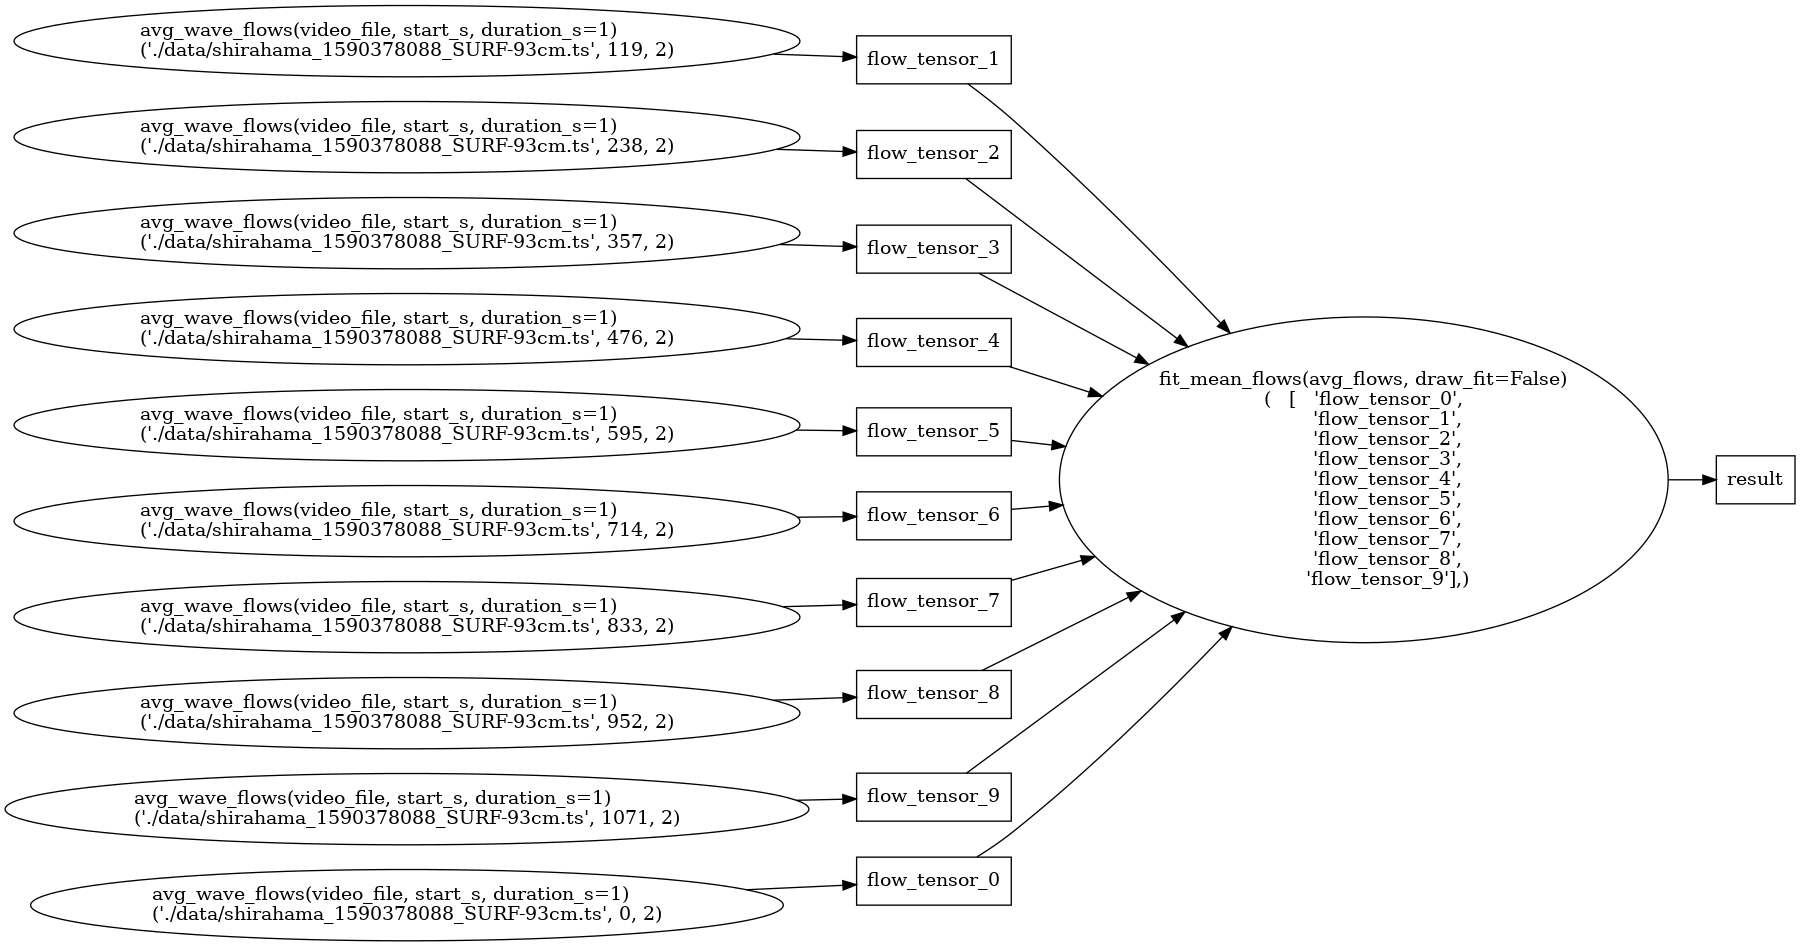

In [ ]:
graphutils.visualize(flow_fit_graph)

## Some key camera  assumption we can make: 
1. Ocean surface is flat (on average, over time)
1. Camera is definitely above wave surface looking down
1. Camera should have only yaw and pitch vs. horizon (approximately zero roll)

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt

def normalized(a, axis=-1, order=2):
    """General function for normalizing the length of a vector to 1"""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def shift_img(img, xshift, yshift):
    M = np.array([[1.,0.,xshift],[0.,1.,yshift]], dtype='float32')
    out_img = cv2.warpAffine(img, M, dsize=img.T.shape, borderMode=cv2.BORDER_TRANSPARENT)
    return out_img

def trim_image(image, xrange, yrange):
    return image[yrange[0]:yrange[1], xrange[0]:xrange[1]]


## Crop and produce an averaged wave vector

In [ ]:
from surfbreak import load_videos
import cv2

video_file = './tmp/shirahama_1590387334_SURF-93cm.ts'

frames = load_videos.decode_frame_sequence(video_file, duration_s=1, start_s=50, RGB=True,
                                              one_image_per_n_frames=2)

Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 


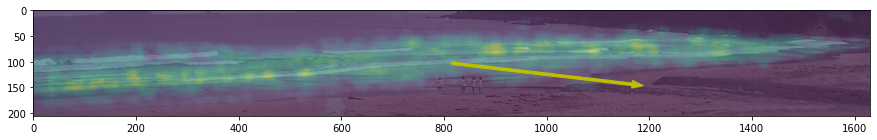

In [ ]:
wave_img = detection.trim_image(frames[0], xrange, yrange)


avg_wave_xdir = detection.trim_image(mean_flow[:,:,0], xrange, yrange).mean()
avg_wave_ydir = detection.trim_image(mean_flow[:,:,1], xrange, yrange).mean()
wave_vector = (avg_wave_xdir*2000, avg_wave_ydir*2000)

mean_flow_mag = np.sqrt(mean_flow[:,:,0]*mean_flow[:,:,0] + mean_flow[:,:,1]*mean_flow[:,:,1])

trimmed_mag = detection.trim_image(mean_flow_mag, xrange, yrange)
center = ((xrange[1] - xrange[0])//2, (yrange[1] - yrange[0])//2)

plt.figure(figsize=(15,5))
plt.imshow(wave_img)
plt.arrow(center[0], center[1], wave_vector[0], wave_vector[1], color='y', width=5)
plt.gca().imshow(trimmed_mag, alpha=0.4)

## Compute a homography matrix to center and scale the surfzone
Get a line fit to the surf zone, and calculate optical flow magnitude at the ends to find the two sets of 4 points that define a homography transform.

In [ ]:
#export
def fit_line(heatmap, plot=False):
    
    high_indicies = np.where(heatmap > heatmap.mean())
    
    high_idx_array = np.dstack(high_indicies)[0][:,::-1]
    
    # https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=fitline#fitline
    line_def = cv2.fitLine(high_idx_array, 1, 0, 1, 0.1)
    # Y is down, X is to right in image space
    vx, vy, x0, y0 = line_def 

    line_half_length = heatmap.shape[1]/3
    x1 = x0 - vx*line_half_length 
    y1 = y0 - vy*line_half_length
    x2 = x0 + vx*line_half_length
    y2 = y0 + vy*line_half_length
    end_points = ((x1,y1), (x2,y2))

    if plot:    
        img = cv2.line(heatmap.copy(), (x1, y1), (x2, y2), .5, thickness=8)
        plt.imshow(img, )
    
    return line_def, end_points

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


array([[ 9.9911165e-01],
       [-4.2141058e-02],
       [ 6.9992444e+02],
       [ 1.0045746e+02]], dtype=float32)

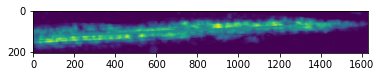

In [ ]:
import numpy as np
line, end_points = fit_line(trimmed_mag, plot=True)
line

### Calculate the homogrophy transform
https://docs.opencv.org/master/d9/dab/tutorial_homography.html

In [ ]:
#export
def flow_mag_at_point(flow_mag, point, windowsize=100, percentile=90):
    xrange = (int(point[0] - windowsize/2), int(point[0] + windowsize/2))
    yrange = (int(point[1] - windowsize/2), int(point[1] + windowsize/2))
    window_mag = trim_image(flow_mag, xrange, yrange)
    # Find the 90th percentile value of the magnitudes which are greater than the mean
    # (Goal is to find the highest "reasonable" value)
    flow_magnitude = np.percentile(window_mag[window_mag > window_mag.mean()],percentile)
    return flow_magnitude

def fit_surfzone_homography_points(magnitude_img):
    """Returns four points aligned to a line fitted through the surfzone, 
       Currently scales to the avg optical flow magnitude of each end of the surfzone (needs improvement)"""
    line, end_points = fit_line(magnitude_img, plot=False)
    leftmag = flow_mag_at_point(magnitude_img, end_points[0], percentile=90)
    rightmag = flow_mag_at_point(magnitude_img, end_points[1], percentile=90)

    dx = line[0]; dy = line[1]

    # Now calculate the position of the four corner points pre-transform
    # Note. here dy is being used for X coordinates and vice/versa because perpendeicular = swapped dx/dy ratio 
    left_top_pt     = (end_points[0][0] - 100*dy*leftmag,  end_points[0][1] + 100*dx*leftmag)
    left_bottom_pt  = (end_points[0][0] + 100*dy*leftmag,  end_points[0][1] - 100*dx*leftmag)
    right_top_pt    = (end_points[1][0] - 100*dy*rightmag, end_points[1][1] + 100*dx*rightmag)
    right_bottom_pt = (end_points[1][0] + 100*dy*rightmag, end_points[1][1] - 100*dx*rightmag)
    pre_warp_corners = np.stack([np.concatenate(tup) for tup in 
                                   [left_top_pt, left_bottom_pt, right_top_pt, right_bottom_pt]], axis=0)
    
    # Calculate the positionb of these same corners post-transform
    # Since this is now aligned to X axis, dy is all 0 and dx is 1.  Also, rightmag is set equal to leftmag
    len_line = np.sqrt((end_points[1][0]-end_points[0][0])**2 + (end_points[1][1]-end_points[0][1])**2)
    post_left_top_pt     = (end_points[0][0],            end_points[0][1] + 100*leftmag)
    post_left_bottom_pt  = (end_points[0][0],            end_points[0][1] - 100*leftmag)
    post_right_top_pt    = (end_points[0][0] + len_line, end_points[0][1] + 100*leftmag)
    post_right_bottom_pt = (end_points[0][0] + len_line, end_points[0][1] - 100*leftmag)
    post_warp_corners = np.stack([np.concatenate(tup) for tup in 
                                 [post_left_top_pt, post_left_bottom_pt, post_right_top_pt, post_right_bottom_pt]], axis=0)

    return pre_warp_corners, post_warp_corners

In [ ]:
for pct in [60,80,90,95]:
    leftmag = flow_mag_at_point(trimmed_mag, end_points[0], percentile=pct)
    rightmag = flow_mag_at_point(trimmed_mag, end_points[1], percentile=pct)
    print(pct, '\t',leftmag, '\t' ,rightmag)

60 	 0.6890892624855041 	 0.4973392605781555
80 	 0.7827463030815125 	 0.5744008421897888
90 	 0.8327141284942627 	 0.6904338836669923
95 	 0.8620972514152525 	 0.7582170486450195


Pre-transform homogrophy points:


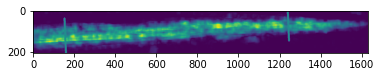

Post-transform homogrophy points:


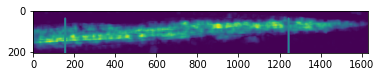

In [ ]:
pre_warp_corners, post_warp_corners = fit_surfzone_homography_points(trimmed_mag) 

img = cv2.line(trimmed_mag.copy(), tuple(pre_warp_corners[0]), tuple(pre_warp_corners[1]), .5, thickness=8)
img = cv2.line(img.copy(), tuple(pre_warp_corners[2]), tuple(pre_warp_corners[3]), .5, thickness=8)

img2 = cv2.line(trimmed_mag.copy(), tuple(post_warp_corners[0]), tuple(post_warp_corners[1]), .5, thickness=8)
img2 = cv2.line(img2.copy(), tuple(post_warp_corners[2]), tuple(post_warp_corners[3]), .5, thickness=8)

print("Pre-transform homogrophy points:")
plt.imshow(img)
plt.show()
print("Post-transform homogrophy points:")
plt.imshow(img2)
plt.show()

Homography matrix:
[[ 7.85112860e-01 -3.31148754e-02  3.41244635e+01]
 [ 2.22430425e-02  9.76691766e-01 -3.47779132e+00]
 [-1.53351774e-04  6.46800305e-06  1.00000000e+00]]

Transformed image:


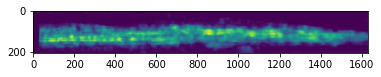

In [ ]:
H, _ = cv2.findHomography(pre_warp_corners, post_warp_corners)
print("Homography matrix:")
print(H)

mag_warped = cv2.warpPerspective(trimmed_mag, H, (trimmed_mag.shape[1], trimmed_mag.shape[0]))

print("\nTransformed image:")
plt.imshow(mag_warped)
plt.show()

### Compare images pre- and post- homography transform

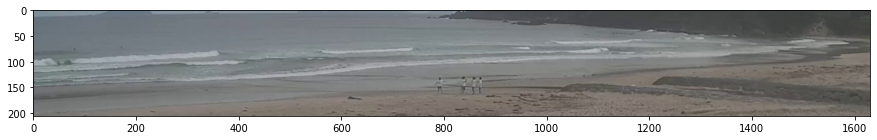

In [ ]:
# Image pre-transform
plt.figure(figsize=(15,5))
plt.imshow(wave_img)

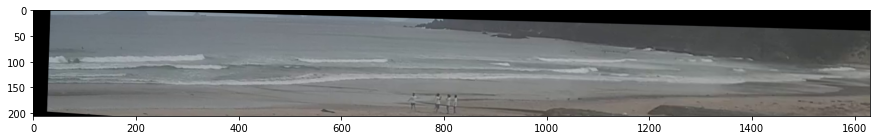

In [ ]:
# Image post-transform
img_warped = cv2.warpPerspective(wave_img, H, (wave_img.shape[1], wave_img.shape[0]))
plt.figure(figsize=(15,5))
plt.imshow(img_warped)

In [ ]:
#export
def pix_to_crop_from_dir(magnitude_img, crop_from, mass_crop_pct=0.05, backoff_pct=0.2, min_backoff_pix=10, ):
    assert crop_from in ["top", 'bottom', 'left', 'right']
    max_to_crop = magnitude_img.sum() * mass_crop_pct
    cropped_sum = 0
    if crop_from in ["top", 'bottom']:
        max_px_idx = magnitude_img.shape[0]
    elif crop_from in ["left", 'right']:
        max_px_idx = magnitude_img.shape[1]

    for i in range(max_px_idx):
        if cropped_sum > max_to_crop:
                return max(0, i - int(backoff_pct * i) - min_backoff_pix)  # subtract margin to back off from edge of image
        else:
            if crop_from is "bottom":
                cropped_sum += magnitude_img[max_px_idx - i - 1].sum()
            elif crop_from is "top":
                cropped_sum += magnitude_img[i].sum()
            elif crop_from is "left":
                cropped_sum += magnitude_img[:,i].sum()
            elif crop_from is "right":
                cropped_sum += magnitude_img[:,max_px_idx - i - 1].sum()

def find_crop_range(magnitude_img):
    """Returns cropped coordinates ((xmin,xmax), (ymin,ymax)) """
    px_bottom = pix_to_crop_from_dir(magnitude_img, 'bottom', mass_crop_pct=0.05, backoff_pct=0.2)
    px_top =    pix_to_crop_from_dir(magnitude_img, 'top',    mass_crop_pct=0.05, backoff_pct=0.4)
    y_crop_mag = magnitude_img[px_top : -1 - px_bottom]
    px_left  = pix_to_crop_from_dir(y_crop_mag, 'left',  mass_crop_pct=0.00001, backoff_pct=0, min_backoff_pix=1)
    px_right = pix_to_crop_from_dir(y_crop_mag, 'right', mass_crop_pct=0.00001, backoff_pct=0, min_backoff_pix=1)
    # Range defined
    crop_range = ((px_left, magnitude_img.shape[1] - px_right),(px_top,  magnitude_img.shape[0] - px_bottom))
    return crop_range

(28, 1631) (40, 184)


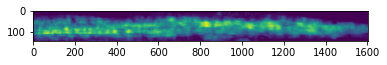

In [ ]:
cx_range, cy_range = find_crop_range(mag_warped)
print(cx_range, cy_range)

plt.imshow(mag_warped[cy_range[0]:cy_range[1],cx_range[0]:cx_range[1]])        

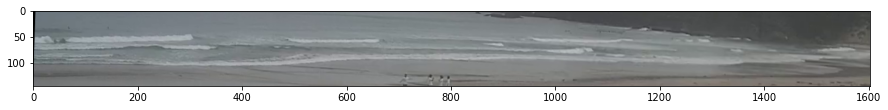

In [ ]:
img_warped = cv2.warpPerspective(wave_img, H, (wave_img.shape[1], wave_img.shape[0]))
plt.figure(figsize=(15,5))
plt.imshow(img_warped[cy_range[0]:cy_range[1],cx_range[0]:cx_range[1]])  

## Now, gather into a convenient function

What we'll need to convert each raw image in the videos

1. Pre-transform surfzone xrange and yrange (Done)  
1. Homography matrix
1. Post-transform xrange and yrange
1. Pipeline to calculate the above across several videos

In [ ]:
from surfbreak import detection, graphutils
import pipelines
import dask
import graphchain

flow_fit_graph = pipelines.vid_to_fit_mean_flow_graph('./tmp/shirahama_1590387334_SURF-93cm.ts', n_samples=10)

with dask.config.set(num_workers=4):
    mean_flow, rx_range, ry_range = graphchain.get(flow_fit_graph, 'result', scheduler=dask.threaded.get)

print("\n#1: Rough surfzone xrange and yrange:")
print(rx_range, ry_range)

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]

#1: Rough surfzone xrange and yrange:
(0, 1631) (364, 570)


In [ ]:
#export
def image_flow_magnitude(mean_flow):
    return np.sqrt(mean_flow[:,:,0]*mean_flow[:,:,0] + mean_flow[:,:,1]*mean_flow[:,:,1])

def fit_homography_to_mean_flow(meanflow, xrange, yrange):
    mean_flow_mag = image_flow_magnitude(meanflow)
    trimmed_mag = detection.trim_image(mean_flow_mag, xrange, yrange)
    pre_warp_corners, post_warp_corners = fit_surfzone_homography_points(trimmed_mag) 
    H, _ = cv2.findHomography(pre_warp_corners, post_warp_corners)
    return H

def warp_trimmed_image(trimmed_image, H):
    return cv2.warpPerspective(trimmed_image, H, (trimmed_image.shape[1], trimmed_image.shape[0]))


def find_surfspot_calibration_params(mean_flow, rx_range, ry_range):
    H = fit_homography_to_mean_flow(mean_flow, rx_range, ry_range)
    
    mean_flow_mag = image_flow_magnitude(mean_flow)
    trimmed_mag = detection.trim_image(mean_flow_mag, rx_range, ry_range)
    mag_warped = warp_trimmed_image(trimmed_mag, H)
    tx_range, ty_range = find_crop_range(mag_warped)
    
    surfspot_calibration_params = {
        'crop_xrange': rx_range,
        'crop_yrange': ry_range,
        'h_matrix': H,
        'warped_xrange':tx_range,
        'warped_yrange':ty_range
    }
    
    return surfspot_calibration_params


def normalize_image(image, crop_xrange, crop_yrange, h_matrix, warped_xrange, warped_yrange):
    trimmed_img = detection.trim_image(image, crop_xrange, crop_yrange)
    warped_img = warp_trimmed_image(trimmed_img, h_matrix)
    return warped_img[warped_yrange[0]:warped_yrange[1], warped_xrange[0]:warped_xrange[1]]


def plot_mean_flow_mag(meanflow_tensor, axis=None, title=None):
    mean_flow_mag = np.sqrt(meanflow_tensor[:,:,0]*meanflow_tensor[:,:,0] + 
                            meanflow_tensor[:,:,1]*meanflow_tensor[:,:,1])
    if axis is not None: 
        axis.imshow(mean_flow_mag)
        axis.set_title(title)
    else: 
        plt.imshow(mean_flow_mag)
        plt.gca().set_title(title)

In [ ]:
H = fit_homography_to_mean_flow(mean_flow, rx_range, ry_range)
print("#2: Homography matrix:")
print(H)

#2: Homography matrix:
[[ 7.85112860e-01 -3.31148754e-02  3.41244635e+01]
 [ 2.22430425e-02  9.76691766e-01 -3.47779132e+00]
 [-1.53351774e-04  6.46800305e-06  1.00000000e+00]]


In [ ]:
mean_flow_mag = image_flow_magnitude(mean_flow)
trimmed_mag = detection.trim_image(mean_flow_mag, rx_range, ry_range)
mag_warped = warp_trimmed_image(trimmed_mag, H)
tx_range, ty_range = find_crop_range(mag_warped)
print("#3: Post-transform xrange and yrange:")
print(tx_range, ty_range)

#3: Post-transform xrange and yrange:
(28, 1631) (40, 184)


In [ ]:
print("#2 (Homography matrix H), and #3 (post-transform xrange and yrange):")
find_surfspot_calibration_params(mean_flow, rx_range, ry_range)

#2 (Homography matrix H), and #3 (post-transform xrange and yrange):


{'crop_xrange': (0, 1631),
 'crop_yrange': (364, 570),
 'h_matrix': array([[ 7.85112860e-01, -3.31148754e-02,  3.41244635e+01],
        [ 2.22430425e-02,  9.76691766e-01, -3.47779132e+00],
        [-1.53351774e-04,  6.46800305e-06,  1.00000000e+00]]),
 'warped_xrange': (28, 1631),
 'warped_yrange': (40, 184)}

### Now accumulate across many videos

In [ ]:
calibration_videos = [
    './data/shirahama_1590387334_SURF-93cm.ts',
    './data/shirahama_1590312313_SURF-101cm.ts',
    './data/shirahama_1592790996_SURF-129cm.ts',
    './data/shirahama_1590479277_SURF-59cm.ts',
    './data/shirahama_1590378088_SURF-93cm.ts'
]

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]
Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]


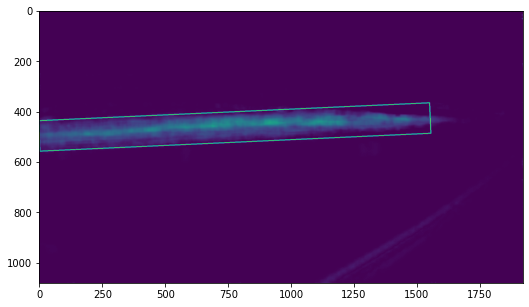

{'crop_xrange': (0, 1554),
 'crop_yrange': (364, 556),
 'h_matrix': array([[ 8.41120966e-01, -3.50704545e-02,  4.48285600e+01],
        [ 2.97091525e-02,  9.70020121e-01, -9.34691562e+00],
        [-9.50009200e-05,  3.96145916e-06,  1.00000000e+00]]),
 'warped_xrange': (39, 1554),
 'warped_yrange': (33, 172)}

In [ ]:
video_mean_flows = []
for vid in calibration_videos:
    flow_fit_graph = pipelines.vid_to_fit_mean_flow_graph(vid, n_samples=10, duration_s=2)

    with dask.config.set(num_workers=4):
        meanflow, xyrange, yrange = graphchain.get(flow_fit_graph, 'result', scheduler=dask.threaded.get)
    video_mean_flows.append(meanflow)

# Ignore the fit ranges from the individual videos, and re-fit across videos
acc_mean_flow, acc_xrange, acc_yrange = detection.fit_mean_flows(video_mean_flows, draw_fit=True)

calibration_parameters = find_surfspot_calibration_params(acc_mean_flow, acc_xrange, acc_yrange)
calibration_parameters

Flow magnitude of the video tensors:


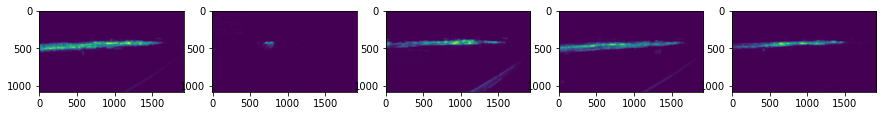

Flow magnitude of the accumulated tensor:
x range:  (0, 1554)   y range:  (364, 556)


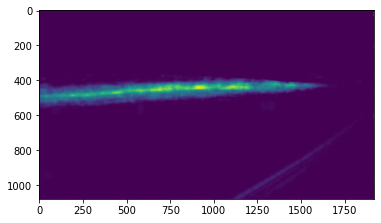

In [ ]:
fig, axes = plt.subplots(ncols=len(video_mean_flows), figsize=(15,5))
for idx, mf in enumerate(video_mean_flows):
    plot_mean_flow_mag(mf, axis=axes[idx])
print("Flow magnitude of the video tensors:")
plt.show()

plot_mean_flow_mag(acc_mean_flow)
print("Flow magnitude of the accumulated tensor:")
print("x range: ", acc_xrange, "  y range: ", acc_yrange)
plt.show()

## Demonstration of using the surfspot normalization parameters
to transform a sequence of images from one video into the static surfspot view

In [ ]:
#export
def run_surfcam_calibration(calibration_videos, num_workers=3):
    """Runs the optical flow fitting pipeline on the calibration videos, then uses the results
       to calculate a set of calibration parameters used by `transform.normalize_image()`"""
    video_mean_flows = []
    for vid in calibration_videos:
        flow_fit_graph = pipelines.vid_to_fit_mean_flow_graph(vid, n_samples=10, duration_s=2)

        with dask.config.set(num_workers=num_workers):
            meanflow, xyrange, yrange = graphchain.get(flow_fit_graph, 'result', scheduler=dask.threaded.get)
        video_mean_flows.append(meanflow)

    # Ignore the fit ranges from the individual videos, and re-fit across videos
    acc_mean_flow, acc_xrange, acc_yrange = detection.fit_mean_flows(video_mean_flows, draw_fit=True)

    calibration_params = find_surfspot_calibration_params(acc_mean_flow, acc_xrange, acc_yrange)
    return calibration_params

def video_file_to_calibrated_image_tensors(video_file, calibration_params, duration_s, start_s, one_image_per_n_frames=6):
    frames = load_videos.decode_frame_sequence(video_file, duration_s=duration_s, start_s=start_s, RGB=True,
                                                  one_image_per_n_frames=one_image_per_n_frames)
    img_tensor = np.stack([normalize_image(frame, **calibration_params) 
                           for frame in frames], axis=3)
    return img_tensor
    

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]
Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]


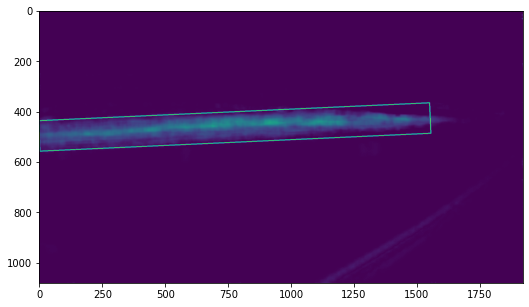

Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 


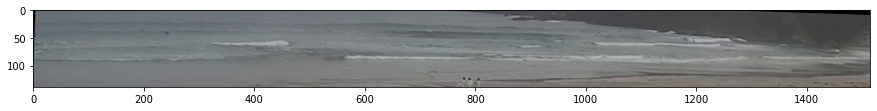

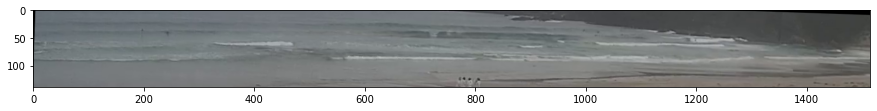

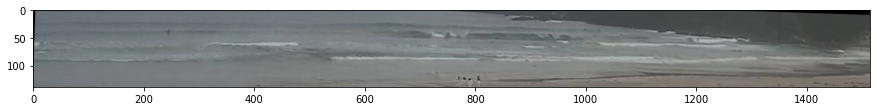

In [ ]:
calibration_params = run_surfcam_calibration(calibration_videos)

video_file = './tmp/shirahama_1590387334_SURF-93cm.ts'
image_tensor = video_file_to_calibrated_image_tensors(video_file, calibration_params, duration_s=1, start_s=0)
for frame_idx in range(3):
    plt.figure(figsize=(15,5))
    plt.imshow(image_tensor[:,:,:,frame_idx*3])
    plt.show()

Decoding ./data/shirahama_1592790996_SURF-129cm.ts  Duration: 20.0m (1200.03s)  FPS: 60.0  Emitting 1/6 of frames 


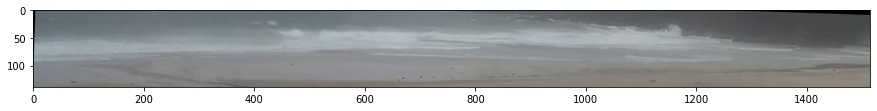

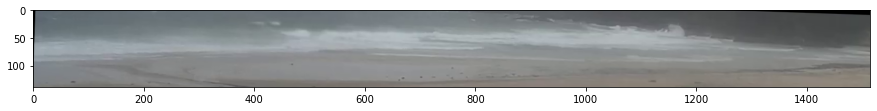

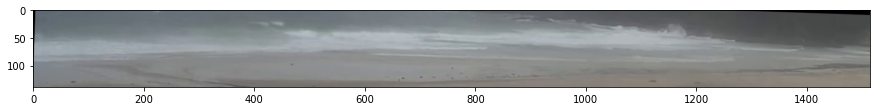

In [ ]:
video_file = './data/shirahama_1592790996_SURF-129cm.ts'
image_tensor = video_file_to_calibrated_image_tensors(video_file, calibration_params, duration_s=1, start_s=0)
for frame_idx in range(3):
    plt.figure(figsize=(15,5))
    plt.imshow(image_tensor[:,:,:,frame_idx*3])
    plt.show()

# Generate calibrated image tensors from video using cached computation graphs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using calibration paramters for shirahama


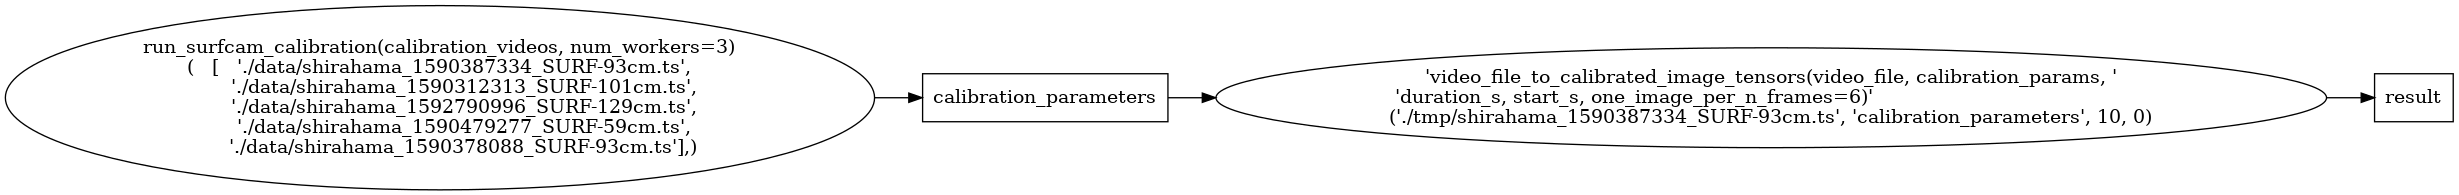

In [ ]:
%load_ext autoreload
%autoreload 2
from surfbreak import graphutils
import pipelines
import graphchain
import dask
import matplotlib.pyplot as plt

# These tensors are 10hz by default (1/6th of the frames from a of 60Hz video)
img_tensor_graph = pipelines.video_to_calibrated_image_tensor('./tmp/shirahama_1590387334_SURF-93cm.ts',
                                                                duration_s=10, start_s=0)
graphutils.visualize(img_tensor_graph)

(139, 1515, 3, 100)


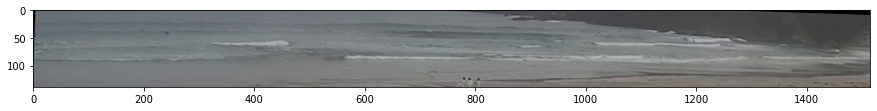

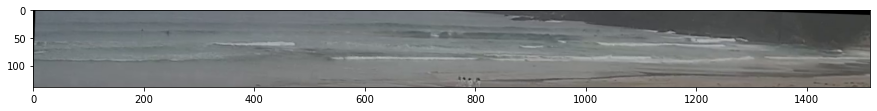

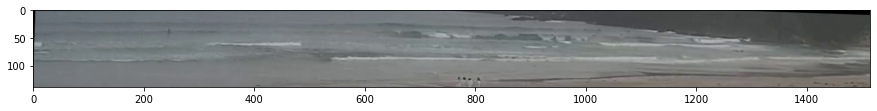

In [ ]:
img_tensor = graphchain.get(img_tensor_graph, 'result')
print(img_tensor.shape)
for frame_idx in range(3):
    plt.figure(figsize=(15,5))
    plt.imshow(img_tensor[:,:,:,frame_idx*4])
    plt.show()

In [ ]:
import nbdev.export as export
export.notebook2script()

Converted 00_load_videos.ipynb.
Converted 01_wave_modeling.ipynb.
Converted 02_wave_detection.ipynb.
Converted 03_perspective_transform.ipynb.
Converted 04_graph_utilities.ipynb.
Converted index.ipynb.
